# A Topological Data Analysis of Static and Contextual Text Embeddings

## Datasets

In [1]:
import urllib.request

pdb_ids = ['4HHB', '1CRK', '1ATP']
for pdb_id in pdb_ids:
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    urllib.request.urlretrieve(url, f'{pdb_id}.pdb')
print("Download complete.")

Download complete.


## Point CLoud

In [2]:
from Bio.PDB import PDBParser
import numpy as np

def get_point_cloud(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    coords = [
        atom.get_coord()
        for atom in structure.get_atoms()
        if atom.element != 'H'
    ]
    return np.array(coords)

# Extract point Cloud for each protein
protein_points = {}
for pdb_id in pdb_ids:
    X = get_point_cloud(f"{pdb_id}.pdb")
    protein_points[pdb_id] = X
    print(f"{pdb_id} point cloud shape:", X.shape)

4HHB point cloud shape: (4779, 3)
1CRK point cloud shape: (12184, 3)
1ATP point cloud shape: (3070, 3)


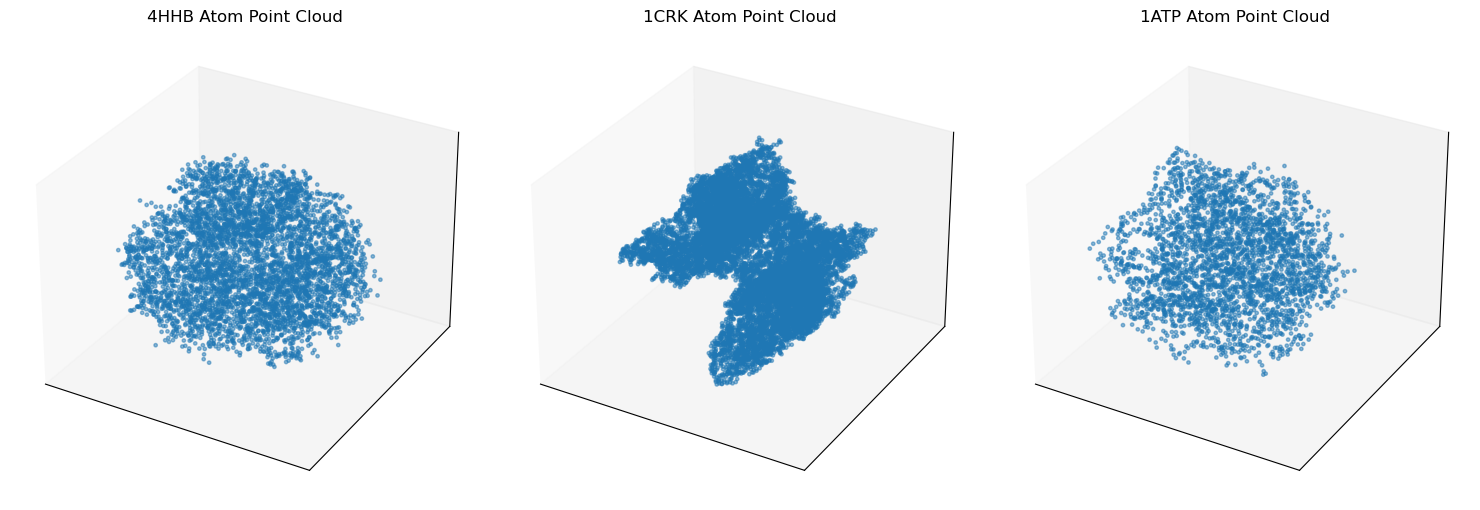

<Figure size 640x480 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
for i, pdb_id in enumerate(pdb_ids):
    X = protein_points[pdb_id]
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=6, alpha=0.5)
    ax.set_title(f"{pdb_id} Atom Point Cloud")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout()
plt.show()
plt.savefig("point clouds.png")

## Persistent Homology (TDA Analysis)

In [4]:
from ripser import ripser

def compute_tda(X, maxdim=2, sample_size=1000):
    """Compute persistent homology for a point cloud."""
    np.random.seed(0)
    if X.shape[0] > sample_size:
        idx = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X
    result = ripser(X_sample, maxdim=maxdim)
    return result['dgms']

tda_results = {}
for pdb_id in pdb_ids:
    diagrams = compute_tda(protein_points[pdb_id])
    tda_results[pdb_id] = diagrams
    print(f"{pdb_id} TDA computation complete.")

4HHB TDA computation complete.
1CRK TDA computation complete.
1ATP TDA computation complete.


## Persistence Diagram

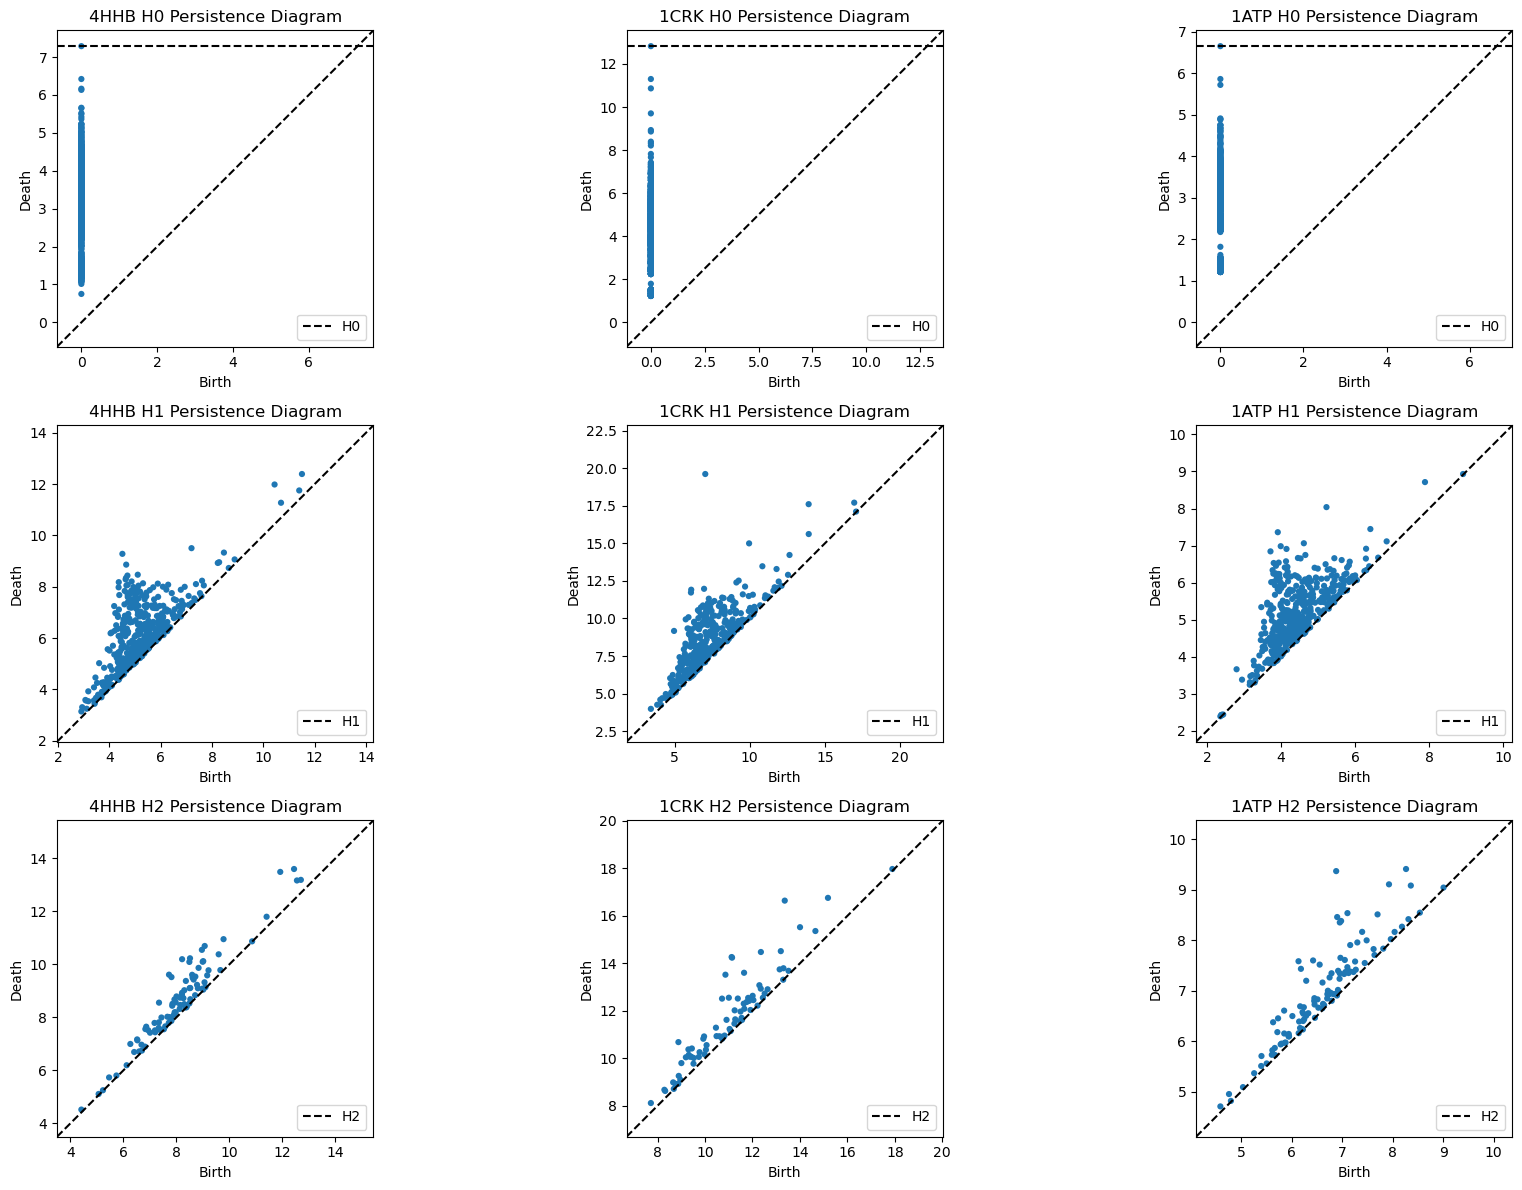

In [5]:
import matplotlib.pyplot as plt
from persim import plot_diagrams

dims = ["H0", "H1", "H2"]
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, dim in enumerate(dims):
    for j, pdb_id in enumerate(pdb_ids):
        diagrams = tda_results[pdb_id]
        if i < len(diagrams):
            plot_diagrams([diagrams[i]], ax=axes[i, j])
            axes[i, j].set_title(f"{pdb_id} {dim} Persistence Diagram")
            # Remove default legend
            legend = axes[i, j].get_legend()
            if legend:
                legend.remove()
            # Add custom legend
            axes[i, j].legend([dim], loc="lower right")
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.savefig("PersistenceDiagrams_3proteins.png")
plt.show()

## Barcode

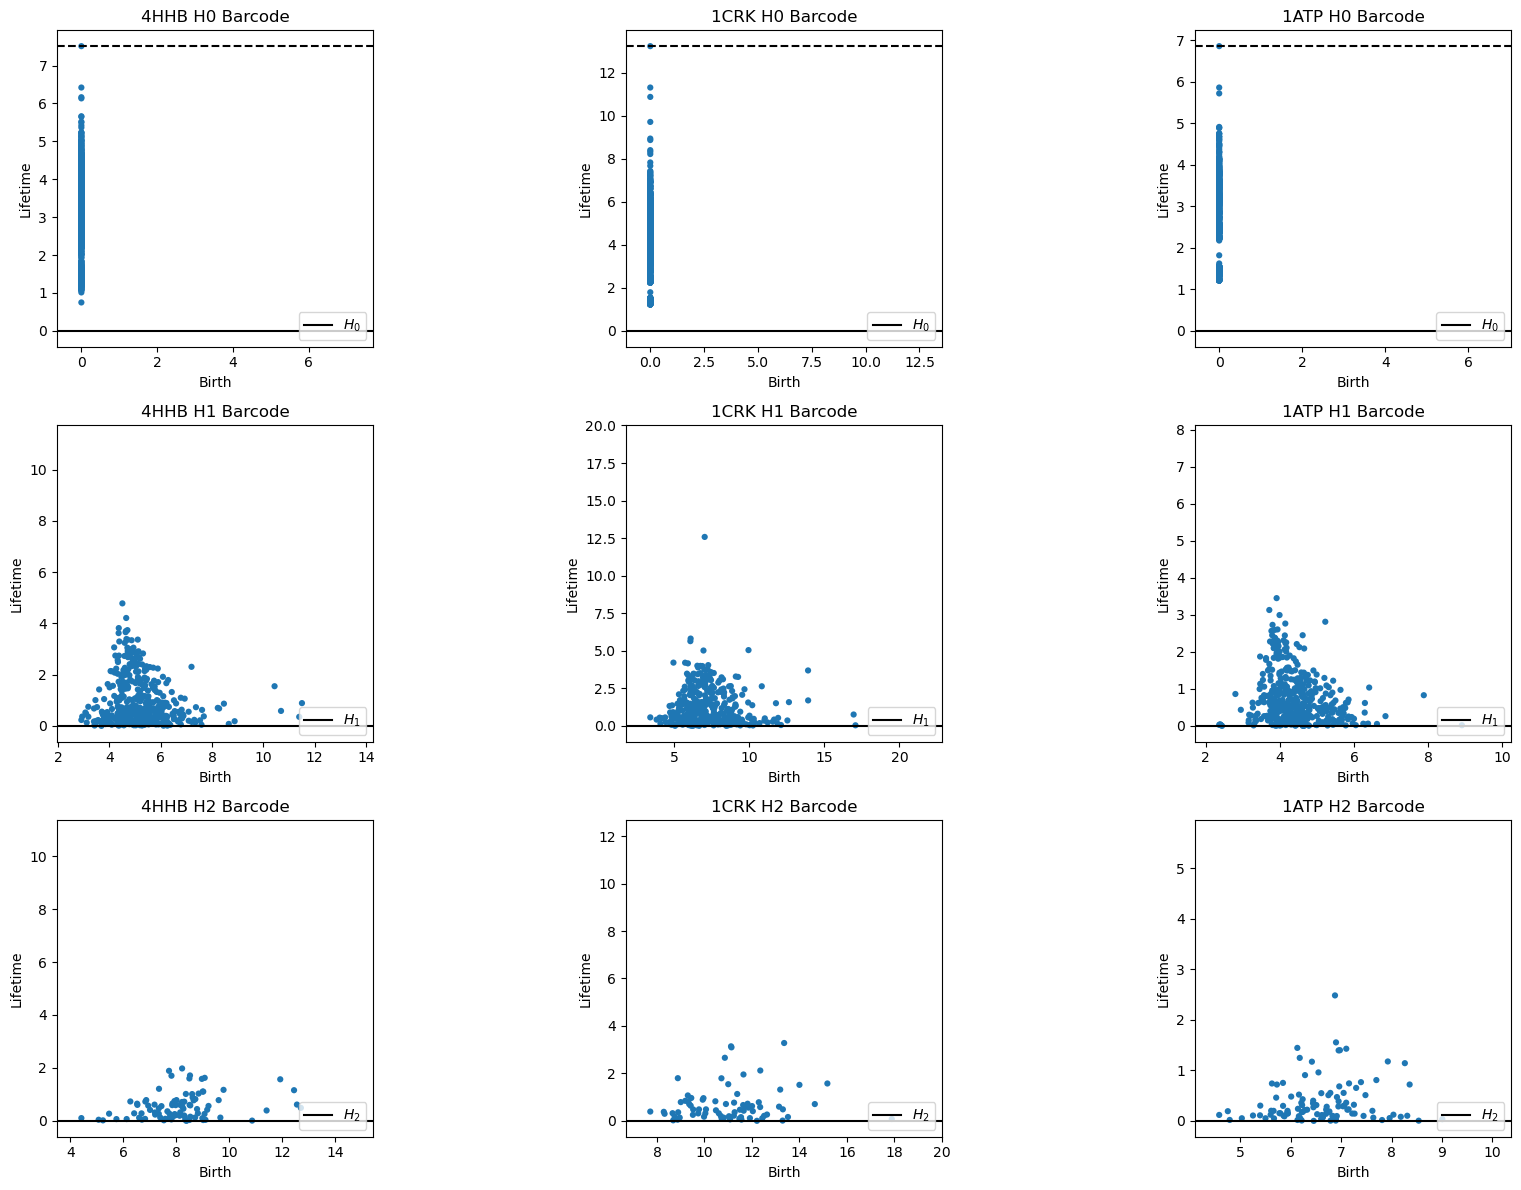

In [6]:
dim_legends = [r"$H_0$", r"$H_1$", r"$H_2$"]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, dim in enumerate(dims):
    for j, pdb_id in enumerate(pdb_ids):
        diagrams = tda_results[pdb_id]
        if i < len(diagrams):
            plot_diagrams([diagrams[i]], ax=axes[i, j], lifetime=True)
            axes[i, j].set_title(f"{pdb_id} {dim} Barcode")
            legend = axes[i, j].get_legend()
            if legend:
                legend.remove()
            axes[i, j].legend([dim_legends[i]], loc="lower right")
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.savefig("Barcodes_3proteins.png")
plt.show()

## Betti Curves& Persistence Entropy

4HHB point cloud shape (after sampling): (800, 3)
1CRK point cloud shape (after sampling): (800, 3)
1ATP point cloud shape (after sampling): (800, 3)
Processing 4HHB...
Processing 1CRK...
Processing 1ATP...


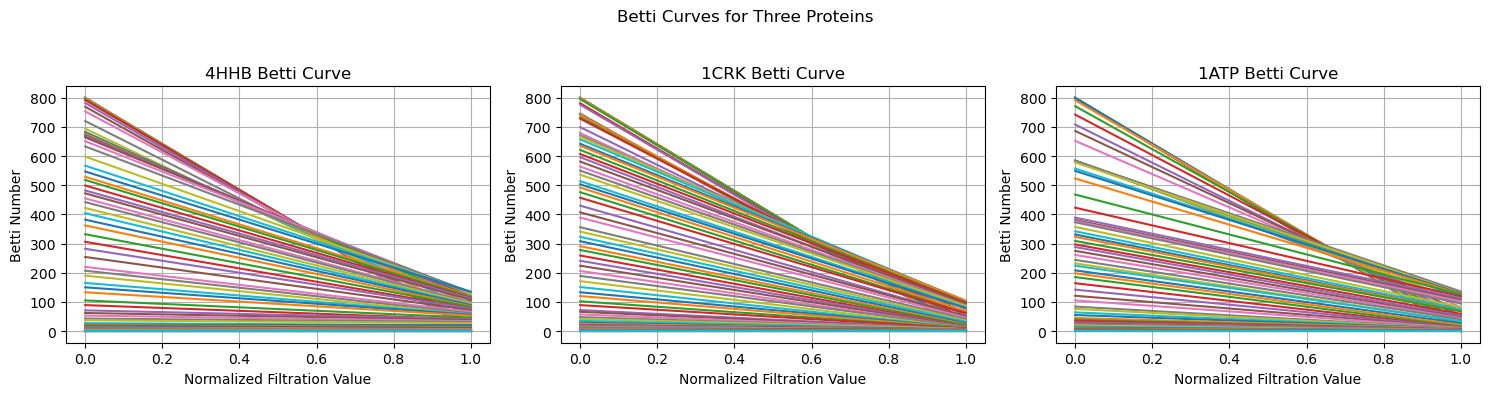

Persistence Entropy Results (H0, H1):
4HHB: H0 = 9.544, H1 = 7.889
1CRK: H0 = 9.543, H1 = 7.637
1ATP: H0 = 9.545, H1 = 7.873


In [9]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, PersistenceEntropy

protein_points = {}
for pdb_id in pdb_ids:
    X = get_point_cloud(f"{pdb_id}.pdb")
    if X.shape[0] > 800:
        idx = np.random.choice(X.shape[0], 800, replace=False)
        X = X[idx]
    protein_points[pdb_id] = X
    print(f"{pdb_id} point cloud shape (after sampling):", X.shape)

vr = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
betti_curves_dict = {}
entropy_dict = {}

for pdb_id in pdb_ids:
    X = protein_points[pdb_id]
    print(f"Processing {pdb_id}...")
    dgm = vr.fit_transform([X])[0]

    # Betti curve
    betti = BettiCurve(n_bins=100)
    betti_curve = betti.fit_transform([dgm])[0]
    betti_curves_dict[pdb_id] = betti_curve

    # Persistence entropy
    entropy = PersistenceEntropy()
    entropy_val = entropy.fit_transform([dgm])[0]
    entropy_dict[pdb_id] = entropy_val

# Betti Curve
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, pdb_id in enumerate(pdb_ids):
    ax = axes[i]
    ax.plot(np.linspace(0, 1, len(betti_curves_dict[pdb_id])), betti_curves_dict[pdb_id])
    ax.set_title(f"{pdb_id} Betti Curve")
    ax.set_xlabel("Normalized Filtration Value")
    ax.set_ylabel("Betti Number")
    ax.grid(True)
plt.suptitle('Betti Curves for Three Proteins')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Betti_Curves.png")
plt.show()

print("Persistence Entropy Results (H0, H1):")
for pdb_id in pdb_ids:
    e = entropy_dict[pdb_id]
    print(f"{pdb_id}: H0 = {e[0]:.3f}, H1 = {e[1]:.3f}")


## Topological Feature Extraction

In [8]:
def get_top_persistent(diagram, top_n=5):
    pers = diagram[:, 1] - diagram[:, 0]
    top_idx = np.argsort(-pers)[:top_n]
    return diagram[top_idx], pers[top_idx]

# Print statistics and save summary
with open("TDA_statistics.txt", "w") as f:
    for pdb_id in pdb_ids:
        diagrams = tda_results[pdb_id]
        h1_count = len(diagrams[1])
        top_h1, pers_h1 = get_top_persistent(diagrams[1])
        summary = (f"{pdb_id} H1 loop count: {h1_count}\n"
                   f"{pdb_id} Top 3 H1 persistences: {pers_h1[:3]}\n")
        print(summary)
        f.write(summary + "\n")

4HHB H1 loop count: 439
4HHB Top 3 H1 persistences: [4.77871704 4.20903683 3.81532955]

1CRK H1 loop count: 381
1CRK Top 3 H1 persistences: [12.57933044  5.81330252  5.64109612]

1ATP H1 loop count: 440
1ATP Top 3 H1 persistences: [3.44974017 3.12941051 2.99299788]



## Wasserstein Distance

In [9]:
from persim import wasserstein

with open("WassersteinDistances.txt", "w") as f:
    f.write("Wasserstein distance between H1 persistence diagrams:\n")
    for i in range(len(pdb_ids)):
        for j in range(i+1, len(pdb_ids)):
            d1 = tda_results[pdb_ids[i]][1]
            d2 = tda_results[pdb_ids[j]][1]
            dist = wasserstein(d1, d2)
            msg = f"{pdb_ids[i]} vs {pdb_ids[j]}: {dist:.3f}"
            print(msg)
            f.write(msg + "\n")

4HHB vs 1CRK: 412.350
4HHB vs 1ATP: 235.918
1CRK vs 1ATP: 512.477


## H1 & H2 Persistence Lifetime Histogram

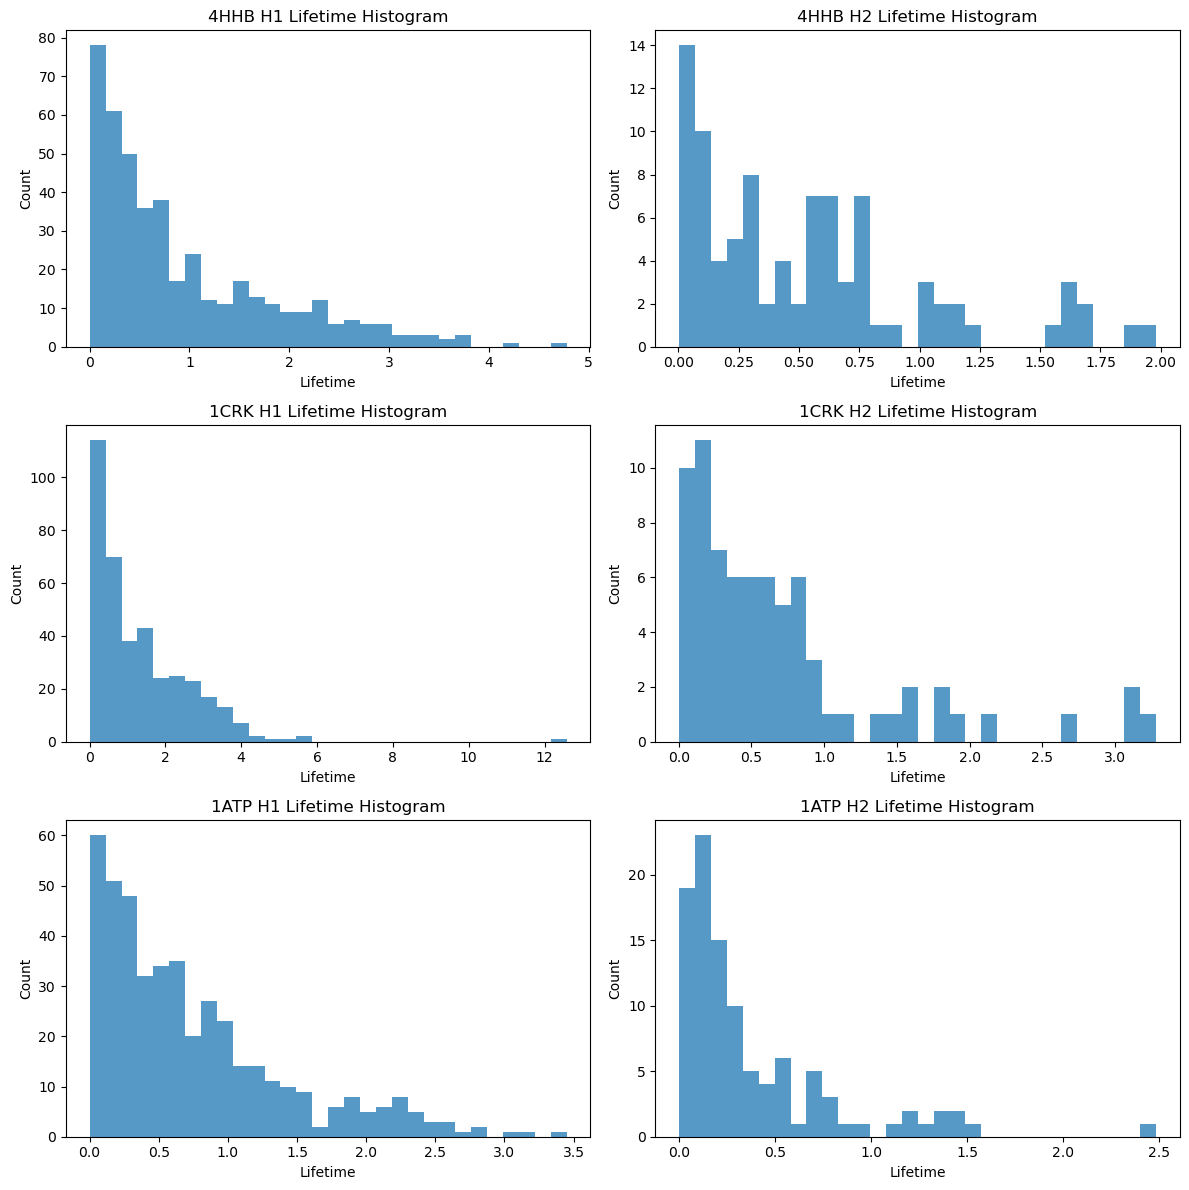

In [14]:
import matplotlib.pyplot as plt
import numpy as np

dims = ['H1', 'H2']
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
bins = 30

for i, pdb_id in enumerate(pdb_ids):
    diagrams = tda_results[pdb_id]
    for j, dname in enumerate(dims):
        if (j+1) < len(diagrams) and diagrams[j+1].shape[0] > 0:
            lifetimes = diagrams[j+1][:,1] - diagrams[j+1][:,0]
            axes[i, j].hist(lifetimes, bins=bins, alpha=0.75)
            axes[i, j].set_title(f"{pdb_id} {dname} Lifetime Histogram")
            axes[i, j].set_xlabel("Lifetime")
            axes[i, j].set_ylabel("Count")
        else:
            axes[i, j].set_visible(False)

plt.tight_layout()
plt.savefig("H1_H2_lifetime_histograms.png")
plt.show()

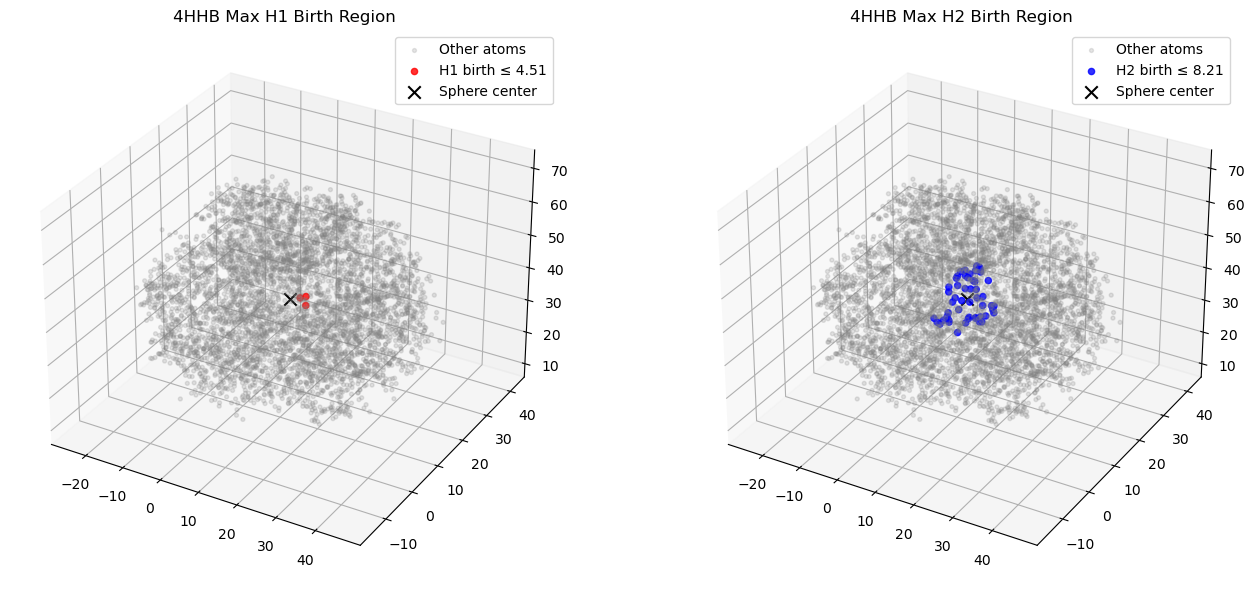

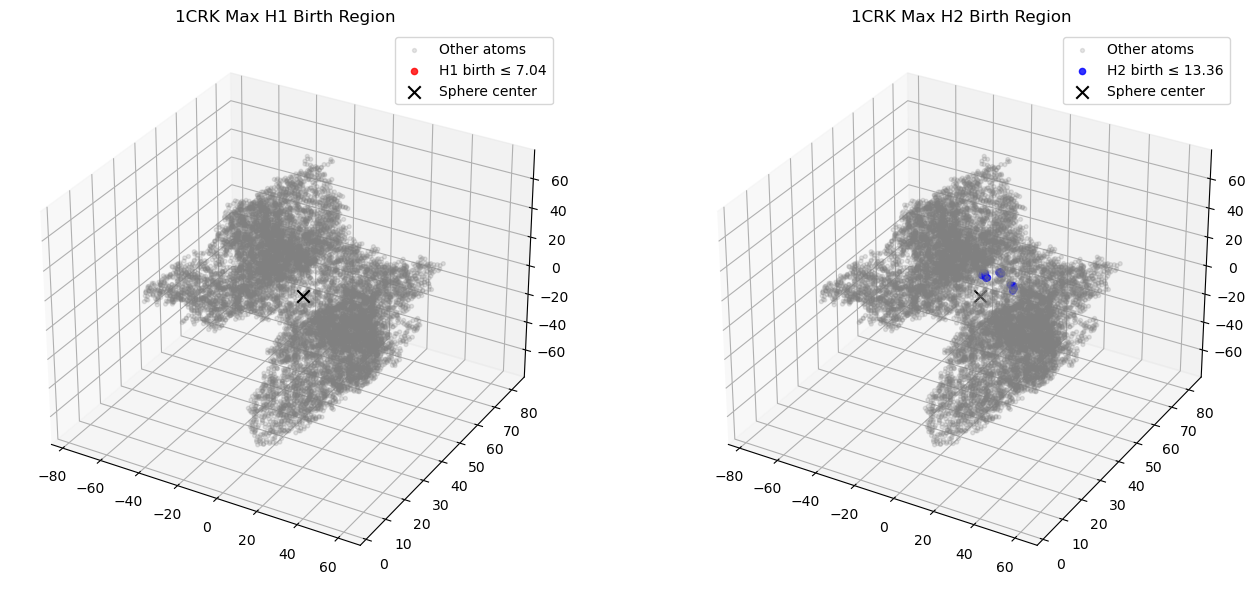

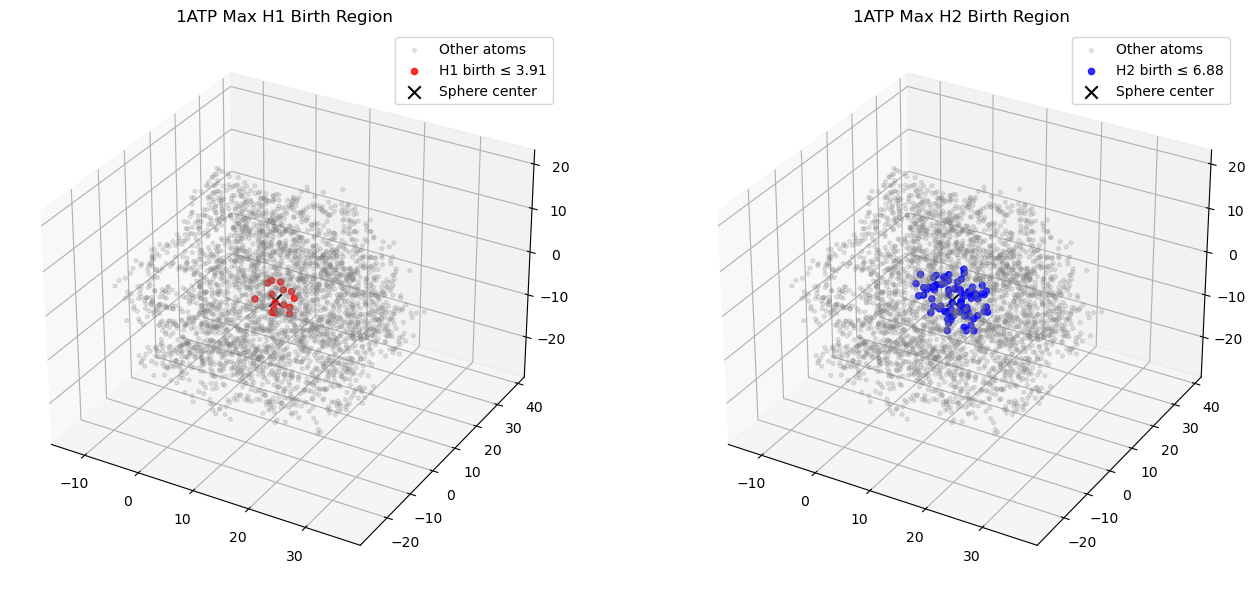

In [15]:
def highlight_birth_sphere(X, birth_radius, center=None):
    if center is None:
        center = X.mean(axis=0)
    dists = np.linalg.norm(X - center, axis=1)
    mask = dists <= birth_radius
    return mask, center

for pdb_id in pdb_ids:
    X = protein_points[pdb_id]
    diagrams = tda_results[pdb_id]
    fig = plt.figure(figsize=(14, 6))

    # H1
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    if len(diagrams) > 1 and diagrams[1].shape[0] > 0:
        h1_lifetime = diagrams[1][:, 1] - diagrams[1][:, 0]
        max_h1_idx = np.argmax(h1_lifetime)
        birth_h1 = diagrams[1][max_h1_idx][0]
        # Use centroid as center for visualization
        mask, center = highlight_birth_sphere(X, birth_h1)
        ax1.scatter(X[~mask, 0], X[~mask, 1], X[~mask, 2], s=8, alpha=0.2, color='grey', label="Other atoms")
        ax1.scatter(X[mask, 0], X[mask, 1], X[mask, 2], s=20, alpha=0.8, color='red', label=f"H1 birth ≤ {birth_h1:.2f}")
        ax1.scatter(center[0], center[1], center[2], s=80, color='black', marker='x', label="Sphere center")
        ax1.set_title(f"{pdb_id} Max H1 Birth Region")
        ax1.legend()
    else:
        ax1.set_visible(False)

    # H2
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    if len(diagrams) > 2 and diagrams[2].shape[0] > 0:
        h2_lifetime = diagrams[2][:, 1] - diagrams[2][:, 0]
        max_h2_idx = np.argmax(h2_lifetime)
        birth_h2 = diagrams[2][max_h2_idx][0]
        mask, center = highlight_birth_sphere(X, birth_h2)
        ax2.scatter(X[~mask, 0], X[~mask, 1], X[~mask, 2], s=8, alpha=0.2, color='grey', label="Other atoms")
        ax2.scatter(X[mask, 0], X[mask, 1], X[mask, 2], s=20, alpha=0.8, color='blue', label=f"H2 birth ≤ {birth_h2:.2f}")
        ax2.scatter(center[0], center[1], center[2], s=80, color='black', marker='x', label="Sphere center")
        ax2.set_title(f"{pdb_id} Max H2 Birth Region")
        ax2.legend()
    else:
        ax2.set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{pdb_id}_H1H2_max_birth_sphere.png")
    plt.show()
